In [1]:
import pandas as pd
import numpy as np

from collections.abc import Iterable 

In [2]:
from utils import plotting, transform, ingest
from forecast import stats, rf

In [3]:
from dateutil.relativedelta import relativedelta

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

side = 16
height = side / np.sqrt(2)

sns.set(rc={"figure.figsize": (side, height)})

In [5]:
cols = ["HOUST", "PERMIT"]
regions = ["NE", "MW", "S", "W"]

regional_hst = [f"HOUST{r}" for r in regions]

In [6]:
raw_df = ingest.import_fred()

parsed_df = transform.standard(raw_df)

Using cached data at data/fred_data.csv


In [23]:
lags = 36

regional_data = parsed_df[regional_hst]

train = regional_data[:"2008-12-01"]
test = regional_data["2009-01-01":]

In [24]:
variables = regional_data.columns.tolist()

In [25]:
predictor = rf.make_forecaster(train, lags = lags, n_jobs = 4, verbose = 1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  2.4min finished


In [26]:
def iterative_forecast(pred, train, lags, periods = 1):
    
    variables = train.columns.tolist()
    
    # Define first period to forecast
    last_day = train.index[-1]
    append_period = last_day - relativedelta(months=lags - 1)
    X = train[append_period:last_day].to_numpy()
    
    y_hat = []
    
    for i in range(periods):
        forecast = pred(X.reshape(-1, 1))
        
        X[:-1] = X[1:]
                
        X[-1] = forecast["mean"]
        
        y_hat.append(forecast)
        
    index = test.index[:len(y_hat)]
    compact_forecast = pd.DataFrame(y_hat, index = index)
    
    df = pd.DataFrame(index = index)
    
    # Expand columns
    for column in compact_forecast.columns:
        
        expanded_column = compact_forecast[column].apply(pd.Series)
        expanded_column = expanded_column.rename(columns = lambda i: f"{variables[i]}_{column}")
        
        df = pd.concat([df[:], expanded_column[:]], axis=1)
        
            
    return df

In [27]:
df_forecast = iterative_forecast(predictor, train, lags, periods = 10)

In [28]:
def plot_var(df_forecast, train, test, variables = []):
    
    pre_sample = train.iloc[-10:]
    post_sample = test.iloc[:len(df_forecast)]

    N = len(variables)
    
    rows = int(np.floor(np.sqrt(N)))
    columns = int(np.ceil(N/rows))

    fig, axes = plt.subplots(rows, columns)
    
    
    iter_axes = axes.reshape(-1) if isinstance(axes, Iterable) else [axes]

    for i, ax in enumerate(iter_axes):
                
        var_name = variables[i]
        
        sns.lineplot(data=pre_sample, y=var_name, x=pre_sample.index,ax = ax, color ="r", marker = "o")
        sns.lineplot(data=post_sample, y=var_name, x=post_sample.index, ax = ax, color="r", marker = "o")

        plt.axvline(test.index[0], linestyle="--")

        sns.lineplot(data=df_forecast[f"{var_name}_mean"], ax = ax, color="g", linestyle="--", marker = "o")
        sns.lineplot(data=df_forecast[f"{var_name}_lower_bound"], ax = ax, color="b", alpha = 0.5)
        sns.lineplot(data=df_forecast[f"{var_name}_upper_bound"], ax = ax, color="b", alpha = 0.5)

        ax.fill_between(df_forecast.index, df_forecast[f"{var_name}_lower_bound"], df_forecast[f"{var_name}_upper_bound"], alpha=0.2)
        
        ax.set_title(f"Forecast {var_name}")
        
    fig.tight_layout()

    return fig

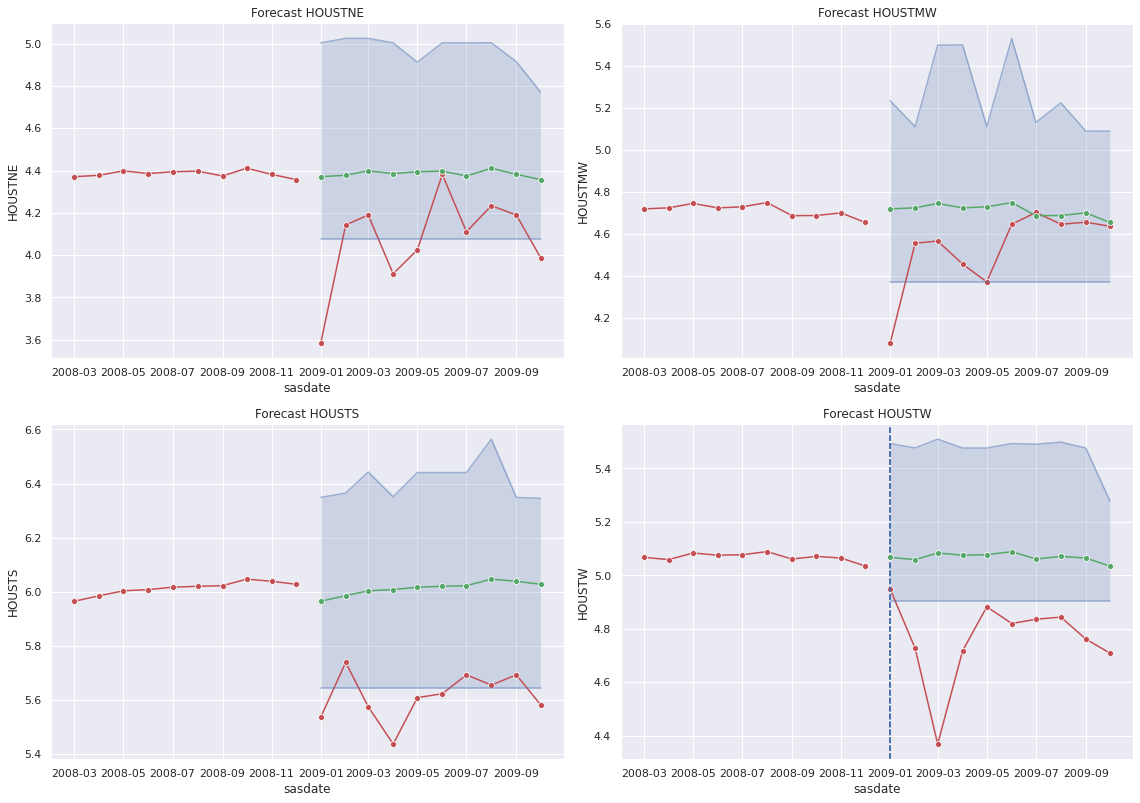

In [29]:
fig = plot_var(df_forecast, train, test, variables=regional_hst)

fig.show()